## 1: Hessian Detector
Implement a hessian detector: <br>
1. Implement a guassian smoothing to the input image <br>
2. Implement a sobel filter as a derivative operator (first and second order) <br>
3. Implement a hessian determinant <br>
4. Threshold the hessian determinant <br>
5. Implement a non-maximum suppression <br>
6. Ignore boundary pixels where any filter keneral would go out of bonuds <br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
def gaussian_kernel_2d(sigma: float, radius: int):
    ax = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    k = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    k /= k.sum()
    return k

def conv2_valid(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Valid convolution (no padding), Output only where kernel fully fits
    kh, kw = kernel.shape
    H, W = img.shape
    out_h = H - kh + 1
    out_w = W - kw + 1
    out = np.empty((out_h, out_w), dtype=np.float64)

    # flip kernel for convolution
    k = kernel[::-1, ::-1]

    for i in range(out_h):
        for j in range(out_w):
            patch = img[i:i+kh, j:j+kw]
            out[i, j] = np.sum(patch * k)
    return out

def sobel_kernels():
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float64)
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]], dtype=np.float64)
    return Kx, Ky

def nms_3x3_valid(score: np.ndarray) -> np.ndarray:
    """3x3 NMS on a score map in valid manner (no padding)."""
    H, W = score.shape
    out = np.zeros_like(score, dtype=bool)

    # Only pixels with full 3x3 neighborhood
    for i in range(1, H-1):
        for j in range(1, W-1):
            patch = score[i-1:i+2, j-1:j+2]
            if score[i, j] == np.max(patch):
                out[i, j] = True
    return out

def hessian_points_detector(
    img_gray: np.ndarray,
    sigma: float = 1.5,
    gauss_radius: int = 2,
    det_thresh: float = 1e-3
):
    img = img_gray.astype(np.float64)

    # Gaussian smoothing (valid)
    G = gaussian_kernel_2d(sigma, gauss_radius)
    sm = conv2_valid(img, G)  # shape: (H-2rG, W-2rG)

    # First derivatives (valid Sobel)
    Kx, Ky = sobel_kernels()
    Ix = conv2_valid(sm, Kx)  # shrinks by 2 in each dim
    Iy = conv2_valid(sm, Ky)

    # Second derivatives (valid Sobel again)
    Ixx = conv2_valid(Ix, Kx)
    Iyy = conv2_valid(Iy, Ky)
    Ixy = conv2_valid(Ix, Ky)  # cross derivative

    # 4) det(H)
    detH = Ixx * Iyy - (Ixy ** 2)

    # 5) threshold
    cand = detH >= det_thresh

    # 6) NMS 3x3
    nms = nms_3x3_valid(detH)
    keep = cand & nms

    # Now we need to map detH/keep back to original image coordinates.
    # Track total shrink:
    # Gaussian valid shrinks by 2*gauss_radius
    # Each Sobel valid shrinks by 2 (because 3x3)
    # We did: sm (shrink 2rG), then Ix/Iy (shrink 2), then Ixx/Iyy/Ixy (shrink 2)
    total_margin = gauss_radius + 2  # rG + 2 (since two 3x3 convs => margin 2)
    # Explanation: valid output corresponds to original indices [total_margin : H-total_margin)

    H, W = img.shape
    detH_full = np.full((H, W), np.nan, dtype=np.float64)
    mask_full = np.zeros((H, W), dtype=bool)

    h2, w2 = detH.shape
    detH_full[total_margin:total_margin+h2, total_margin:total_margin+w2] = detH
    mask_full[total_margin:total_margin+h2, total_margin:total_margin+w2] = keep

    pts = np.argwhere(mask_full)  # (row, col) in original image coords
    points = [tuple(p) for p in pts]

    return points, detH_full, mask_full

Using the main consideration when calling the hessian point detector is the det_threshold, this determines what is considered a point. So if this is too high then we will not get enough points. If this is too low we will get too many points, leading to more noise being present in the dataset. The sigma controls the smoothing in the gaussian blur which impact the noise in the image. Too much smoothing can lead to a reduction in small details in the image. The gauss radius impact the size of the blur.

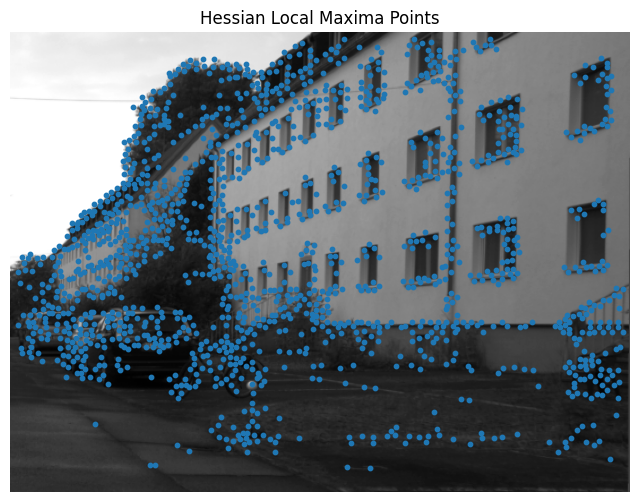

In [105]:
img_path = "road.png" 
img_color = Image.open(img_path).convert("RGB")
img_color = np.array(img_color)

img_gray = (
    0.299 * img_color[:, :, 0] +
    0.587 * img_color[:, :, 1] +
    0.114 * img_color[:, :, 2]
)

img_gray = img_gray / 255.0

points, detH_full, mask_full = hessian_points_detector(
    img_gray,
    sigma=2.0,
    gauss_radius=3,
    det_thresh=0.02
)

plt.figure(figsize=(8,8))
plt.imshow(img_gray, cmap="gray")

ys = [p[0] for p in points]
xs = [p[1] for p in points]

plt.scatter(xs, ys, s=10) 
plt.title("Hessian Local Maxima Points")
plt.axis("off")
plt.show()

In [70]:
print(len(points))

1513


## Question 2: Ransac Pipeline <br>
1. Input feature points from Hessian detector <br>
2. Random Sampling from feature points for a potential candidate line <br>
3. Line model estimation for ax + by + c = 0 <br>
4. Inlier selection based on a threshold <br>
5. Best model selection based on inlinear count <br>
6. Adaptive Iteration control based on inlier count <br>
7. Accept the model based on a threshold of minimum inliers resulting in a better fit <br>
8. Remove inliers from the set of feature points to prevent reuse <br>
9. Repeat for k fixed lines <br>
10. Compute the line direction <br>
11. Project inliners onto line direction <br>
12. Determine segment endpoints <br>
13. Plot inliners and line segments <br> 

In [ ]:
def line_from_two_points(p1, p2, eps=1e-12):
    
    y1, x1 = p1
    y2, x2 = p2

    if abs(x1 - x2) < eps and abs(y1 - y2) < eps:
        return None

    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1

    n = np.hypot(a, b)
    if n < eps:
        return None

    return (a / n, b / n, c / n)

def point_line_distances(points_rc, line_abc):

    # Returns distances shape (N,)
    
    a, b, c = line_abc
    y = points_rc[:, 0].astype(np.float64)
    x = points_rc[:, 1].astype(np.float64)
    return np.abs(a * x + b * y + c)

def ransac_find_one_line(points_rc, dist_thresh, max_iters, min_inliers, confidence=0.99, rng=None):
    
    # Finds one line with RANSAC. Returns (best_line_abc, inlier_idx, used_iters)
    # If not found, returns (None, None, used_iters)
    
    if rng is None:
        rng = np.random.default_rng()

    N = points_rc.shape[0]
    if N < 2:
        return None, None, 0

    best_line = None
    best_inliers = None
    best_count = 0
    
    s = 2
    it = 0
    it_cap = max_iters

    while it < it_cap:
        # sample 2 distinct points
        i1, i2 = rng.choice(N, size=2, replace=False)
        line = line_from_two_points(points_rc[i1], points_rc[i2])
        if line is None:
            it += 1
            continue

        d = point_line_distances(points_rc, line)
        inliers = np.where(d <= dist_thresh)[0]
        count = inliers.size

        if count > best_count:
            best_count = count
            best_line = line
            best_inliers = inliers

            # update iteration cap using current inlier ratio (best guess)
            w = best_count / N
            w = np.clip(w, 1e-6, 1 - 1e-6)
            it_needed = int(np.ceil(np.log(1 - confidence) / np.log(1 - (w ** s))))
            it_cap = min(it_cap, max(it_needed, 1))

        # early stop if already good enough
        if best_count >= min_inliers:
            # you can either stop immediately or keep going a bit to improve
            # here: stop once we hit min_inliers and have iterated at least a few steps
            if it > 20:
                break

        it += 1

    if best_line is None or best_count < min_inliers:
        return None, None, it

    return best_line, best_inliers, it

def ransac_find_k_lines(points, k=4, dist_thresh=2.0, max_iters=2000, min_inliers=80, confidence=0.99, seed=0):
    
    # Finds k lines, removing inliers after each accepted line
    rng = np.random.default_rng(seed)

    points_rc_all = np.array(points, dtype=int)
    remaining_idx = np.arange(points_rc_all.shape[0])
    remaining_points = points_rc_all.copy()

    found = []
    total_iters_used = []

    for _ in range(k):
        line, inliers_local, used_iters = ransac_find_one_line(
            remaining_points,
            dist_thresh=dist_thresh,
            max_iters=max_iters,
            min_inliers=min_inliers,
            confidence=confidence,
            rng=rng
        )
        total_iters_used.append(used_iters)

        if line is None:
            break

        inliers_rc = remaining_points[inliers_local]
        inliers_idx_original = remaining_idx[inliers_local]

        found.append({
            "line_abc": line,
            "inliers_rc": inliers_rc,
            "inlier_idx_original": inliers_idx_original
        })

        # remove inliers so they can't be reused
        keep_mask = np.ones(remaining_points.shape[0], dtype=bool)
        keep_mask[inliers_local] = False
        remaining_points = remaining_points[keep_mask]
        remaining_idx = remaining_idx[keep_mask]

        if remaining_points.shape[0] < 2:
            break

    return found, total_iters_used

In [ ]:
def line_direction_from_abc(line_abc):

    a, b, _ = line_abc

    # Compute a direction vector perpendicular to the normal (a,b)
    d = np.array([-b, a], dtype=np.float64)

    # Normalize so that ||d|| = 1 (important for projection)
    n = np.linalg.norm(d)
    return d / (n + 1e-12)  # small epsilon avoids division by zero


def segment_endpoints_from_inliers(inliers_rc, line_abc):

    # Convert (row, col) to (x, y) coordinates
    # x = col, y = row
    y = inliers_rc[:, 0].astype(np.float64)
    x = inliers_rc[:, 1].astype(np.float64)
    pts_xy = np.stack([x, y], axis=1)

    # Get unit direction vector along the line
    d = line_direction_from_abc(line_abc)

    # Project each inlier onto the line direction
    # t is the scalar projection value for each point
    # This tells us how far along the line each point lies
    t = pts_xy @ d

    # Select extreme projections
    # These correspond to the endpoints of the segment
    p1_xy = pts_xy[np.argmin(t)]  # smallest projection
    p2_xy = pts_xy[np.argmax(t)]  # largest projection

    # Convert endpoints back to (row, col) format
    p1_rc = (int(round(p1_xy[1])), int(round(p1_xy[0])))
    p2_rc = (int(round(p2_xy[1])), int(round(p2_xy[0])))

    return p1_rc, p2_rc


def plot_lines_and_inliers(img_gray, found_lines):
    plt.figure(figsize=(8,8))
    plt.imshow(img_gray, cmap="gray")
    ax = plt.gca()

    for item in found_lines:
        inliers = item["inliers_rc"]
        line = item["line_abc"]

        # Plot inliers
        # Each inlier is shown as a 3x3 square to make support visible
        for (r, c) in inliers:
            ax.add_patch(Rectangle((c - 1, r - 1),
                                   3, 3,
                                   fill=False,
                                   linewidth=1))

        # Compute and draw finite line segment
        # We connect the extreme inliers
        (r1, c1), (r2, c2) = segment_endpoints_from_inliers(inliers, line)

        # Matplotlib expects x first (col), then y (row)
        plt.plot([c1, c2], [r1, r2], linewidth=2)

    plt.axis("off")
    plt.title("RANSAC lines (segments) and inliers (3×3 squares)")
    plt.show()

Key takeways here, the dis_threshold is the most important parameter to tweak. If threshold is too low, we may reject a line that has strong supports but fails to meet the threshold, while we may accept a line with weak supports if this is set too high. Max iterations typically should be set relatively high as this will impact the likelihood of finding a line with a lot of supports. Min inliers also increases the quality of the line as it means more inliers should be present when forming a strong line. By setting min inliers as a function of the total number of points from the hessain detector we make sure that we don't oversample or undersample when trying to find a line.

Found 4 lines
Iterations used per line: [21, 21, 21, 21]


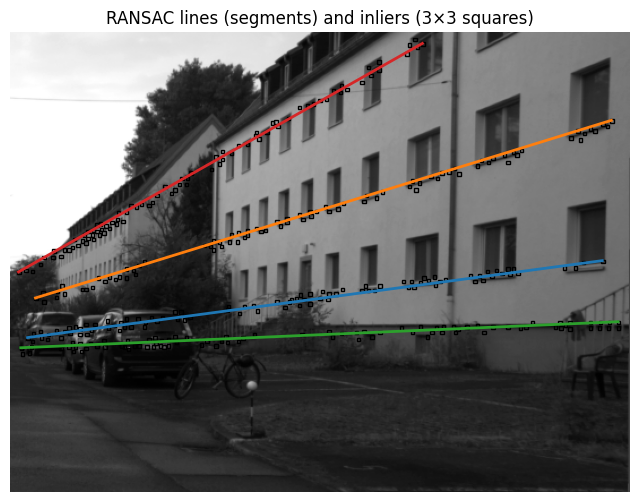

In [106]:
found_lines, iters_used = ransac_find_k_lines(
    points,
    k=4,
    dist_thresh=5.0,
    max_iters=2000,
    min_inliers=int(0.03 * len(points)),
    confidence=0.99,
    seed=0
)

print(f"Found {len(found_lines)} lines")
print("Iterations used per line:", iters_used)

plot_lines_and_inliers(img_gray, found_lines)

This shows the number of inliners used for each line printed on the above picture

In [72]:
for i, line in enumerate(found_lines):
    print(f"Line {i+1}: {len(line['inliers_rc'])} inliers")

Line 1: 92 inliers
Line 2: 82 inliers
Line 3: 86 inliers
Line 4: 84 inliers


## 3: Hough Transform <br>
1. Points vote in p-theta space <br>
2. Accumulator peaks indentifies strongest lines <br>
3. Peaks are converted to line equations <br>
4. Inliners are computed geometrically <br>
5. Line segments are constructed from extreme inliners <br>
6. Results are visualized <br>

In [ ]:
def build_hough_accumulator(points_rc, img_shape, theta_bin_deg=1.0, rho_bin_px=1.0):
    """
    points_rc: (N,2) array of (row,col)
    img_shape: (H,W)
    theta_bin_deg: bin size in degrees (e.g., 1.0)
    rho_bin_px: bin size in pixels (e.g., 1.0)
    Returns:
      A: accumulator (rho_bins, theta_bins)
      thetas: theta values (radians) at bin centers
      rhos: rho values (pixels) at bin centers
    """
    H, W = img_shape
    points_rc = np.asarray(points_rc, dtype=np.float64)
    ys = points_rc[:, 0]
    xs = points_rc[:, 1]

    # theta bins
    theta_step = np.deg2rad(theta_bin_deg)
    thetas = np.arange(0.0, np.pi, theta_step)
    T = len(thetas)

    # rho bins
    rho_max = np.hypot(H - 1, W - 1)
    rho_step = rho_bin_px
    rhos = np.arange(-rho_max, rho_max + rho_step, rho_step)
    R = len(rhos)

    A = np.zeros((R, T), dtype=np.int32)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # Vote: for each point, for each theta, compute rho and bin it
    # Vectorized over theta for each point
    for x, y in zip(xs, ys):
        rho_vals = x * cos_t + y * sin_t  # shape (T,)
        rho_idx = np.round((rho_vals - rhos[0]) / rho_step).astype(int)
        valid = (rho_idx >= 0) & (rho_idx < R)
        A[rho_idx[valid], np.arange(T)[valid]] += 1

    return A, thetas, rhos

def nms_peaks_2d(A, num_peaks=4, nms_radius=8, min_votes=1):
    """
    Find top peaks in accumulator using simple non-maximum suppression.
    nms_radius is in bins
    Returns list of (rho_i, theta_i, votes)
    """
    A_work = A.copy()
    peaks = []
    for _ in range(num_peaks):
        idx = np.unravel_index(np.argmax(A_work), A_work.shape)
        peak_val = A_work[idx]
        if peak_val < min_votes:
            break
        r_i, t_i = idx
        peaks.append((r_i, t_i, int(peak_val)))

        # suppress neighborhood
        r0, r1 = max(0, r_i - nms_radius), min(A_work.shape[0], r_i + nms_radius + 1)
        t0, t1 = max(0, t_i - nms_radius), min(A_work.shape[1], t_i + nms_radius + 1)
        A_work[r0:r1, t0:t1] = 0

    return peaks

def line_abc_from_rho_theta(rho, theta):
    # Function acts to convert from polar coordinates to line coordinates
    a = np.cos(theta)
    b = np.sin(theta)
    c = -rho
    # already normalized because cos^2+sin^2 = 1
    return (a, b, c)

def point_line_dist(points_rc, line_abc):
    a, b, c = line_abc
    y = points_rc[:, 0].astype(np.float64)
    x = points_rc[:, 1].astype(np.float64)
    return np.abs(a * x + b * y + c)  # normalized distance

In [ ]:
def line_direction_from_abc(line_abc):
    a, b, _ = line_abc
    d = np.array([-b, a], dtype=np.float64)  # direction vector
    d /= (np.linalg.norm(d) + 1e-12)
    return d

def segment_endpoints_from_inliers(inliers_rc, line_abc):
    # project inliers onto direction and take extremes
    y = inliers_rc[:, 0].astype(np.float64)
    x = inliers_rc[:, 1].astype(np.float64)
    pts_xy = np.stack([x, y], axis=1)

    d = line_direction_from_abc(line_abc)
    t = pts_xy @ d
    p1_xy = pts_xy[np.argmin(t)]
    p2_xy = pts_xy[np.argmax(t)]

    p1_rc = (int(round(p1_xy[1])), int(round(p1_xy[0])))
    p2_rc = (int(round(p2_xy[1])), int(round(p2_xy[0])))
    return p1_rc, p2_rc

def plot_lines_inliers_and_accumulator(img_gray, points_rc, lines, A, title_suffix=""):
    # show accumulator
    plt.figure(figsize=(6,5))
    A_norm = A.astype(np.float64)
    if A_norm.max() > 0:
        A_norm /= A_norm.max()
    plt.imshow(A_norm, cmap="gray", aspect="auto", origin="lower")
    plt.title(f"Hough accumulator (normalized){title_suffix}")
    plt.xlabel("theta bin")
    plt.ylabel("rho bin")
    plt.show()

    # show overlay
    plt.figure(figsize=(8,8))
    plt.imshow(img_gray, cmap="gray")
    ax = plt.gca()

    for item in lines:
        inliers = item["inliers_rc"]
        (r1, c1), (r2, c2) = item["segment_rc"]

        # inliers as 3×3 squares
        for (r, c) in inliers:
            ax.add_patch(Rectangle((c - 1, r - 1), 3, 3, fill=False, linewidth=1))

        # segment between extreme inliers
        plt.plot([c1, c2], [r1, r2], linewidth=2)

    plt.title(f"Hough lines (segments) and inliers (3×3 squares){title_suffix}")
    plt.axis("off")
    plt.show()

In [ ]:
def hough_find_4_lines(points, img_shape, theta_bin_deg, rho_bin_px,
                       inlier_dist_thresh=2.0, nms_radius=10, min_votes=20):
    points_rc = np.array(points, dtype=int)

    A, thetas, rhos = build_hough_accumulator(
        points_rc, img_shape, theta_bin_deg=theta_bin_deg, rho_bin_px=rho_bin_px
    )

    peaks = nms_peaks_2d(A, num_peaks=4, nms_radius=nms_radius, min_votes=min_votes)

    lines = []
    used_inliers = np.zeros(points_rc.shape[0], dtype=bool)

    for r_i, t_i, votes in peaks:
        rho = rhos[r_i]
        theta = thetas[t_i]
        line_abc = line_abc_from_rho_theta(rho, theta)

        d = point_line_dist(points_rc, line_abc)
        inliers = np.where((d <= inlier_dist_thresh) & (~used_inliers))[0]

        # mark these inliers as used, this avoids reusing the same inliners
        used_inliers[inliers] = True

        inliers_rc = points_rc[inliers]
        if inliers_rc.shape[0] >= 2:
            p1_rc, p2_rc = segment_endpoints_from_inliers(inliers_rc, line_abc)
        else:
            p1_rc, p2_rc = None, None

        lines.append({
            "rho": float(rho),
            "theta": float(theta),
            "votes": int(votes),
            "line_abc": line_abc,
            "inliers_rc": inliers_rc,
            "segment_rc": (p1_rc, p2_rc)
        })

    return lines, A

# 3a <br>
First run of the hough transform

When calling the hough transform function the theta bin and rho bin as this will impact the resolution of the accumulator space. Samller bin sizes increases resolution but spread votes across bins making peaks less distinct. NMS radius controls how close together detected peaks can be in the parameter space. If the value is too low multiple peaks may be selected for the same line, whereas for large values lines close together may be suppressed. The min votes as a quality indicator telling us that if there aren't enough points in a peak then the line is weak.

(3a) Line 1: votes=26, inliers=70, theta(deg)=90.0, rho=255.8
(3a) Line 2: votes=20, inliers=77, theta(deg)=73.0, rho=227.8
(3a) Line 3: votes=18, inliers=53, theta(deg)=53.0, rho=181.8
(3a) Line 4: votes=17, inliers=44, theta(deg)=1.0, rho=189.8


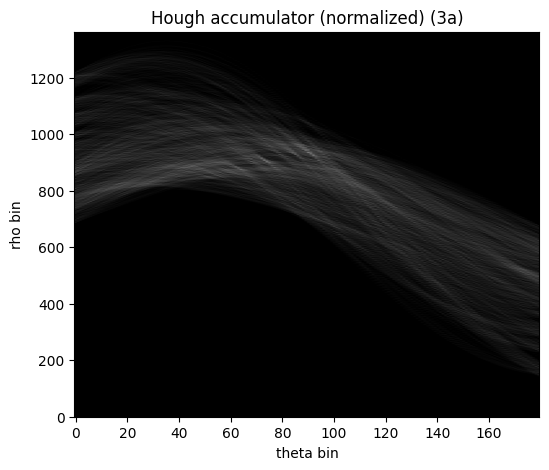

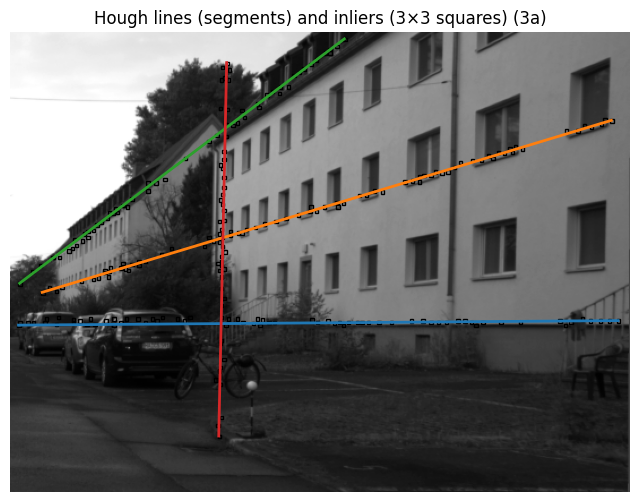

In [ ]:
# points: output list from your Hessian detector
# img_gray: grayscale image (H,W)
H, W = img_gray.shape

theta_bin_deg = 1.0
rho_bin_px = 1.0

lines_a, A_a = hough_find_4_lines(
    points, (H, W),
    theta_bin_deg=theta_bin_deg,
    rho_bin_px=rho_bin_px,
    inlier_dist_thresh=4.0,  
    nms_radius=20,
    min_votes=15
)

for i, L in enumerate(lines_a, 1):
    print(f"(3a) Line {i}: votes={L['votes']}, inliers={len(L['inliers_rc'])}, "
          f"theta(deg)={np.rad2deg(L['theta']):.1f}, rho={L['rho']:.1f}")

plot_lines_inliers_and_accumulator(img_gray, np.array(points), lines_a, A_a, title_suffix=" (3a)")

# 3b: 
Second run of hough transform with bins halved

(3b) Line 1: votes=29, inliers=73, theta(deg)=90.00, rho=255.79
(3b) Line 2: votes=13, inliers=44, theta(deg)=90.00, rho=183.79
(3b) Line 3: votes=12, inliers=32, theta(deg)=0.00, rho=175.79
(3b) Line 4: votes=11, inliers=44, theta(deg)=103.00, rho=152.29


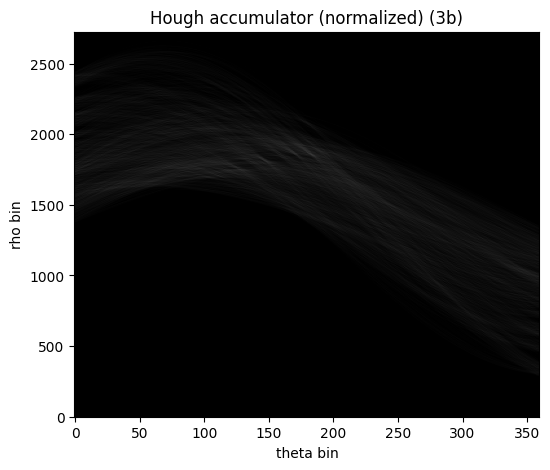

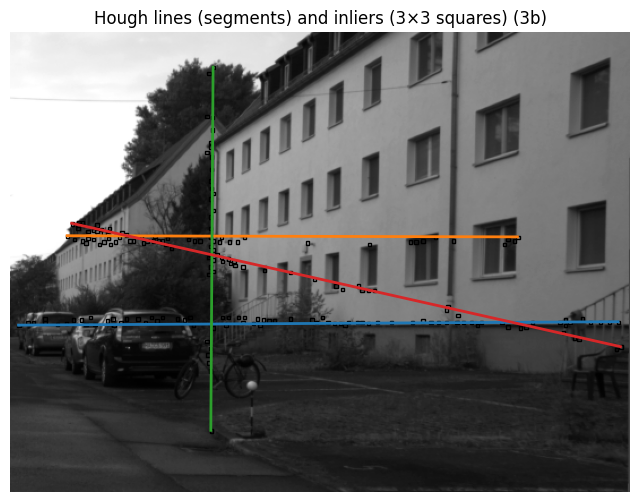

In [98]:
lines_b, A_b = hough_find_4_lines(
    points, (H, W),
    theta_bin_deg=theta_bin_deg / 2,
    rho_bin_px=rho_bin_px / 2,
    inlier_dist_thresh=4.0,
    nms_radius=40,   
    min_votes=10
)

for i, L in enumerate(lines_b, 1):
    print(f"(3b) Line {i}: votes={L['votes']}, inliers={len(L['inliers_rc'])}, "
          f"theta(deg)={np.rad2deg(L['theta']):.2f}, rho={L['rho']:.2f}")

plot_lines_inliers_and_accumulator(img_gray, np.array(points), lines_b, A_b, title_suffix=" (3b)")

# 3c: 
Third run of Hough Transform with bins doubled

(3c) Line 1: votes=37, inliers=70, theta(deg)=90.0, rho=260.8
(3c) Line 2: votes=27, inliers=77, theta(deg)=72.0, rho=234.8
(3c) Line 3: votes=24, inliers=52, theta(deg)=56.0, rho=184.8
(3c) Line 4: votes=22, inliers=48, theta(deg)=16.0, rho=130.8


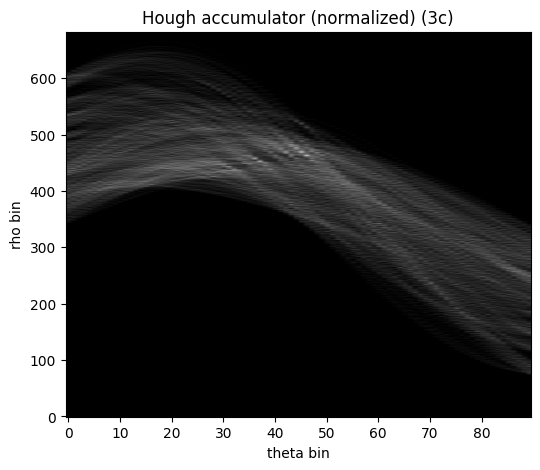

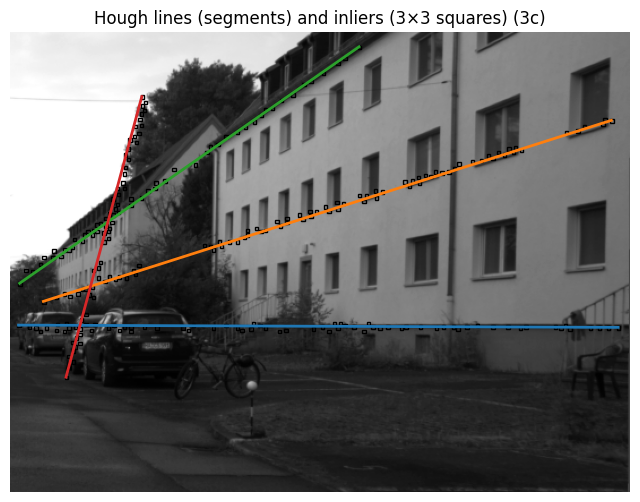

In [93]:
lines_c, A_c = hough_find_4_lines(
    points, (H, W),
    theta_bin_deg=theta_bin_deg * 2,
    rho_bin_px=rho_bin_px * 2,
    inlier_dist_thresh=4.0,
    nms_radius=10,   
    min_votes=15
)

for i, L in enumerate(lines_c, 1):
    print(f"(3c) Line {i}: votes={L['votes']}, inliers={len(L['inliers_rc'])}, "
          f"theta(deg)={np.rad2deg(L['theta']):.1f}, rho={L['rho']:.1f}")

plot_lines_inliers_and_accumulator(img_gray, np.array(points), lines_c, A_c, title_suffix=" (3c)")